In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

## 0. 探索数据

In [2]:
from keras.datasets import boston_housing
from keras import layers
from keras import models
from keras import callbacks

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


### 导入数据

In [3]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

print('Training data shape:{}, training prices shape:{}'.format(x_train.shape, y_train.shape))
print('Test data shape:{}, test prices shape:{}'.format(x_test.shape, y_test.shape))

Training data shape:(404, 13), training prices shape:(404,)
Test data shape:(102, 13), test prices shape:(102,)


### 显示部分数据

In [29]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
            'DIS', 'RAD', 'TAX', 'PTRATION', 'B     ', 'LSTAT', 'MEDV']
for f in features:
    print('{:<7}'.format(f), end='\t')
print('')
    
for features_val, price in zip(x_train[:20], y_train[:20]):
    for val in features_val:
        print('{:<7}'.format(val), end='\t')
    print(price)

CRIM   	ZN     	INDUS  	CHAS   	NOX    	RM     	AGE    	DIS    	RAD    	TAX    	PTRATION	B      	LSTAT  	MEDV   	
1.23247	0.0    	8.14   	0.0    	0.538  	6.142  	91.7   	3.9769 	4.0    	307.0  	21.0   	396.9  	18.72  	15.2
0.02177	82.5   	2.03   	0.0    	0.415  	7.61   	15.7   	6.27   	2.0    	348.0  	14.7   	395.38 	3.11   	42.3
4.89822	0.0    	18.1   	0.0    	0.631  	4.97   	100.0  	1.3325 	24.0   	666.0  	20.2   	375.52 	3.26   	50.0
0.03961	0.0    	5.19   	0.0    	0.515  	6.037  	34.5   	5.9853 	5.0    	224.0  	20.2   	396.9  	8.01   	21.1
3.69311	0.0    	18.1   	0.0    	0.713  	6.376  	88.4   	2.5671 	24.0   	666.0  	20.2   	391.43 	14.65  	17.7
0.28392	0.0    	7.38   	0.0    	0.493  	5.708  	74.3   	4.7211 	5.0    	287.0  	19.6   	391.13 	11.74  	18.5
9.18702	0.0    	18.1   	0.0    	0.7    	5.536  	100.0  	1.5804 	24.0   	666.0  	20.2   	396.9  	23.6   	11.3
4.0974 	0.0    	19.58  	0.0    	0.871  	5.468  	100.0  	1.4118 	5.0    	403.0  	14.7   	396.9  	26.42  	15.6
2.15505	0.0   

#### 房价和犯罪率的关系

+ 通过结果我们可以看到，犯罪率和房价有很大的关系，犯罪率低的区域房价明显要高，最贵的那些房子所在区域都是犯罪率低的区域。

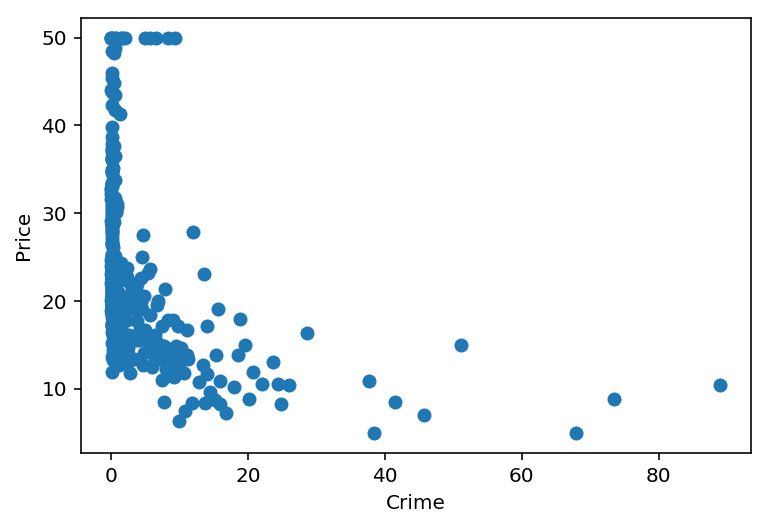

In [37]:
crime = x_train[:, 0]
plt.scatter(crime, y_train)
plt.xlabel('Crime')
plt.ylabel('Price')
plt.show()

#### 是否靠河

+ 从结果上看，靠河的房价普遍高于不靠河的房价，房价最高的房子基本靠河
+ 不靠河也有价格高的房子，但是被视作离群值。

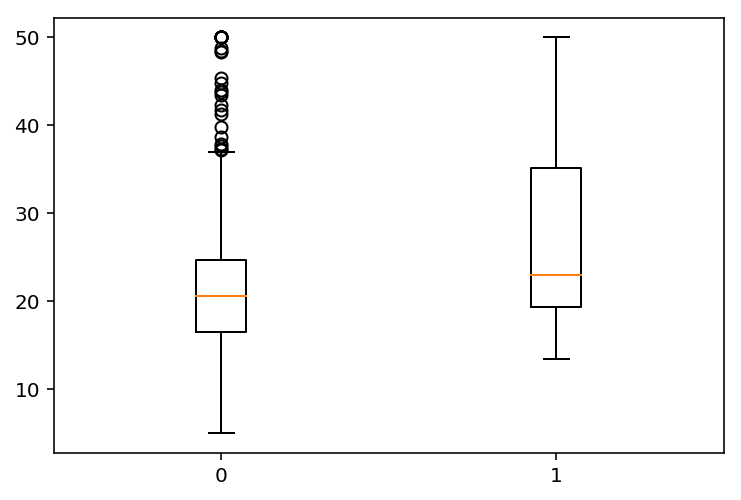

In [44]:
chas = x_train[:, 3]
price_chas = y_train[chas == 1]
price_no_chas = y_train[chas == 0]
plt.boxplot([price_no_chas, price_chas], labels=['0', '1'])
plt.show()

#### 来个汇总

+ 可以看到，有些特征能够很好的反映房价，例如犯罪率(CRIM)，LSTAT, B, RM等等
+ 有些则难以从中判断房价，例如RAD， TAX

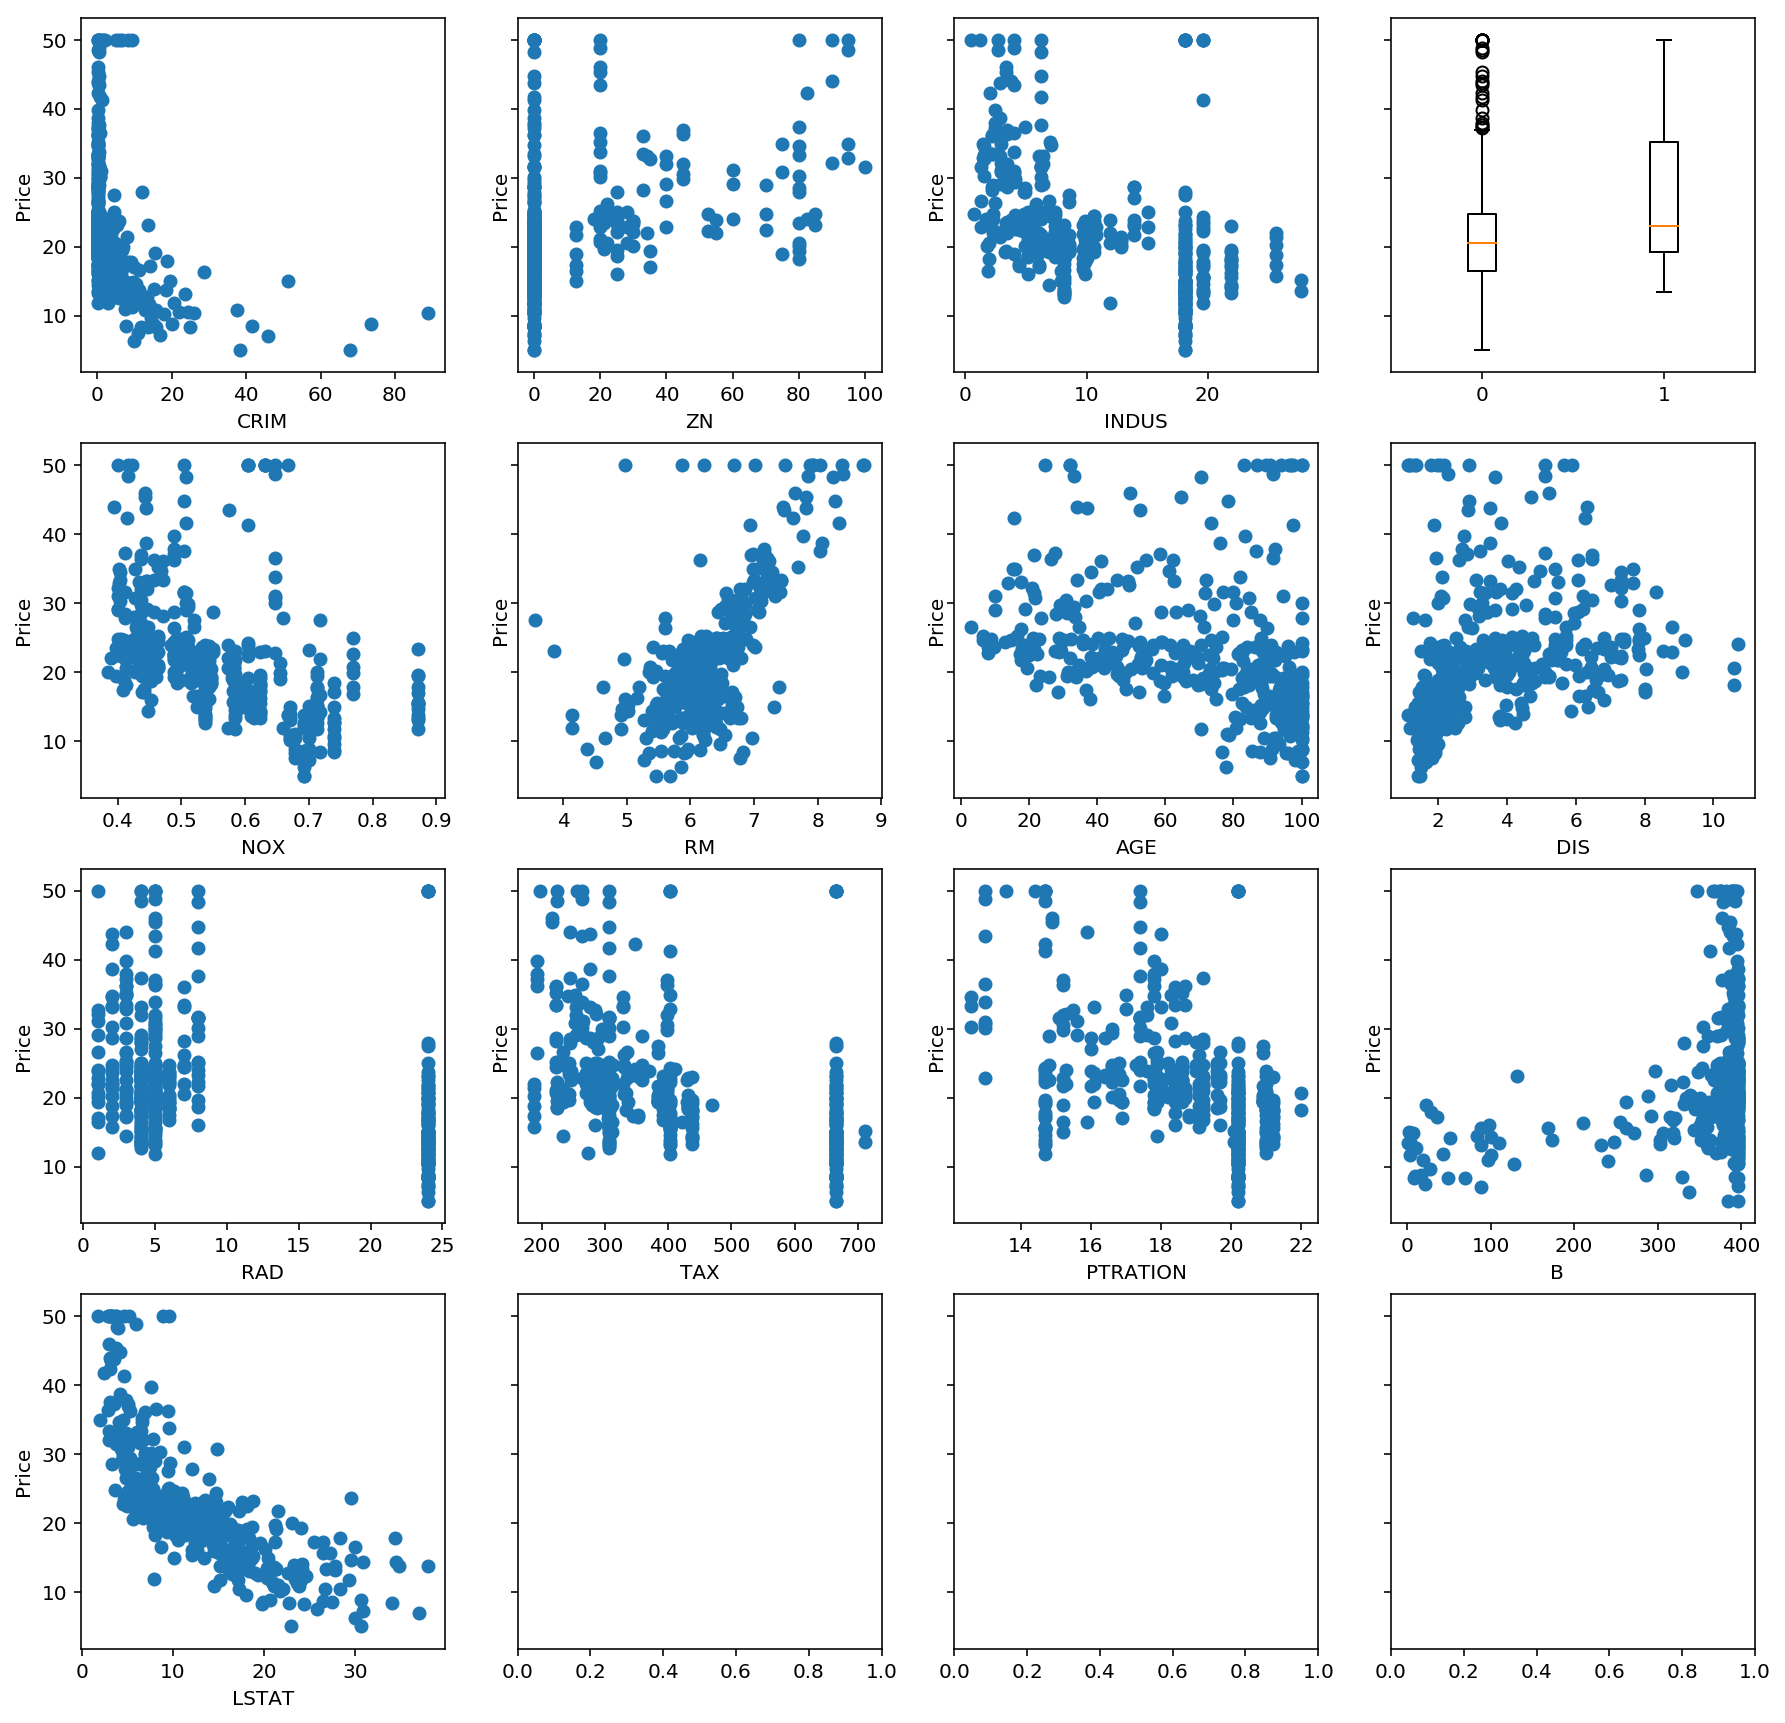

In [57]:
features_without_price = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATION', 'B     ', 'LSTAT']

fig, axes = plt.subplots(4,4, sharey=True, figsize=(15,15))
for i, f in enumerate(features_without_price, 0):
    plot_rows = i // 4
    plot_cols = i % 4
    if f == 'CHAS':
        chas = x_train[:, 3]
        price_chas = y_train[chas == 1]
        price_no_chas = y_train[chas == 0]
        axes[plot_rows, plot_cols].boxplot([price_no_chas, price_chas], labels=['0', '1'])
    else:
        f_val = x_train[:, i]
        axes[plot_rows, plot_cols].scatter(f_val, y_train)
        axes[plot_rows, plot_cols].set_xlabel(f)
        axes[plot_rows, plot_cols].set_ylabel('Price')
plt.show()

## 1. 定义问题

+ 输入数据： $x\in R^n$, n是特征个数
+ 希望的输出：房价
+ 回归问题

## 2. 衡量指标

+ 回归问题，用MAE(Mean Absolute Error; 平均绝对误差)

## 3. 验证策略

+ 训练样本很少，因此k-fold validation是很好的选择

## 4. 准备数据

In [4]:
# 数据归一化，注意'CHAS'的值 0 或者 1，无需归一化
chas_train = x_train[:, 3]
chas_test = x_test[:, 3]

mean = np.mean(x_train, axis=0)
x_train -= mean
std = np.std(x_train, axis=0)
x_train /= std

x_test -= mean
x_test /= std

x_train[:, 3] = chas_train
x_test[:, 3] = chas_test

## 5. 简单模型

+ 这个问题的base line 是什么？不太清楚，大概取个平均值对付一下
+ 6.59左右，说明如果取房价的平均值来预测房价，大概误差是6500美元左右，差距挺大的

In [5]:
mean_value = np.mean(y_train)
baseline_value = np.mean(np.abs(y_test - mean_value))
print('Base line value:{}'.format(baseline_value))

Base line value:6.533042127742185


#### 建立一个简单模型

In [67]:
def build_base_model():
    model = models.Sequential()
    
    model.add(layers.Dense(32, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(1, activation=None))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    return model

In [69]:
# K-fold validation
k = 4
num_val_samples = len(x_train) // k
all_score = []
for i in range(k):
    x_val = x_train[i*num_val_samples : (i+1)*num_val_samples]
    y_val = y_train[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_x_train = np.concatenate([x_train[:i*num_val_samples],
                                      x_train[(i+1)*num_val_samples:]], axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val_samples],
                                      y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_base_model()
    model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=1, verbose=0)
    val_loss, val_mae = model.evaluate(x_val, y_val)
    print('MAE:{}'.format(val_mae))
    all_score.append(val_mae)
    
print('Mean Score:{}'.format(np.mean(all_score)))

101/101 [==============================] - 0s 255us/step
MAE:4.367843151092529
101/101 [==============================] - 0s 355us/step
MAE:4.813835068504409
101/101 [==============================] - 0s 640us/step
MAE:4.371486975414919
101/101 [==============================] - 0s 631us/step
MAE:6.346890519161035
Mean Score:4.975013928543223


## 6. 调整参数

In [9]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    #model.add(layers.Dropout(0.2))
    
    #model.add(layers.BatchNormalization())    
    model.add(layers.Dense(1, activation=None))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    return model

In [10]:
# 平滑曲线
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    smoothed_points.append(points[0])
    
    for point in points[1:]:
        previous = smoothed_points[-1]
        smoothed_points.append( previous*factor + point * (1-factor) )
        
    return smoothed_points

1-fold	 MAE:2.1139200915676533
2-fold	 MAE:2.3213165556794344
3-fold	 MAE:2.4103674963205166
4-fold	 MAE:2.397814279806496
102/102 [==============================] - 0s 113us/step
Test MAE score:2.7559990508883607


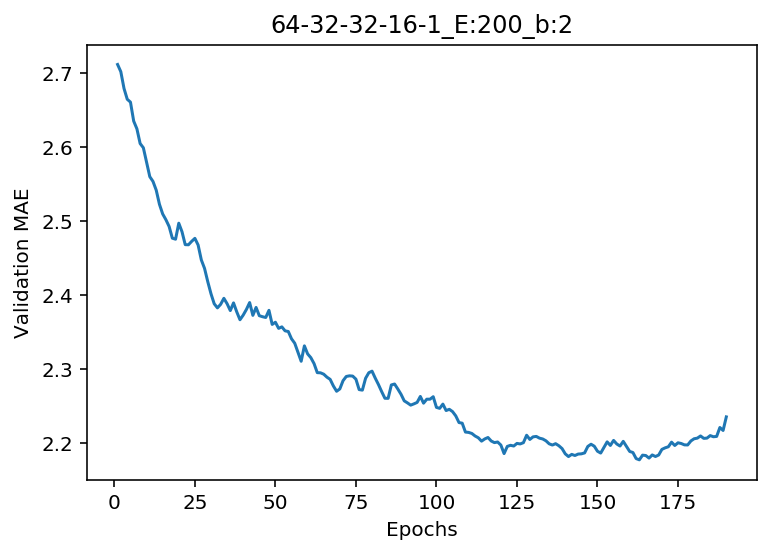

In [46]:
# K-fold validation
k = 4
num_val_samples = len(x_train) // k
all_mae_histories = []
num_epochs = 200
batch_size = 2
for i in range(k):
    x_val = x_train[i*num_val_samples : (i+1)*num_val_samples]
    y_val = y_train[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_x_train = np.concatenate([x_train[:i*num_val_samples],
                                      x_train[(i+1)*num_val_samples:]], axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val_samples],
                                      y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_data=(x_val, y_val))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    print('{}-fold\t MAE:{}'.format(i+1, np.mean(mae_history)))

test_mae_loss, test_mae_score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test MAE score:{}'.format(test_mae_score))

# plot the validation scores
    
average_mae_history = np.mean(all_mae_histories, axis=0)
smoothed_points = smooth_curve(average_mae_history[10:])

layer_shapes = []
for layer in model.layers:
    layer_shapes.append(str(layer.output_shape[-1]))
    
fig_title = '-'.join(layer_shapes)
fig_title += str("_E{}_b{}".format(num_epochs, batch_size))
plt.plot(range(1, len(smoothed_points)+1), smoothed_points)
plt.title(fig_title)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.savefig(fig_title + '.png')
plt.show()

In [49]:
# 做最终的训练
final_epochs = 160
model = build_model()
model.fit(x_train, y_train, epochs=final_epochs, batch_size=batch_size, verbose=0)
test_mae_loss, test_mae_score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test MAE score:{}'.format(test_mae_score))

102/102 [==============================] - 1s 7ms/step
Test MAE score:2.3922921349020565


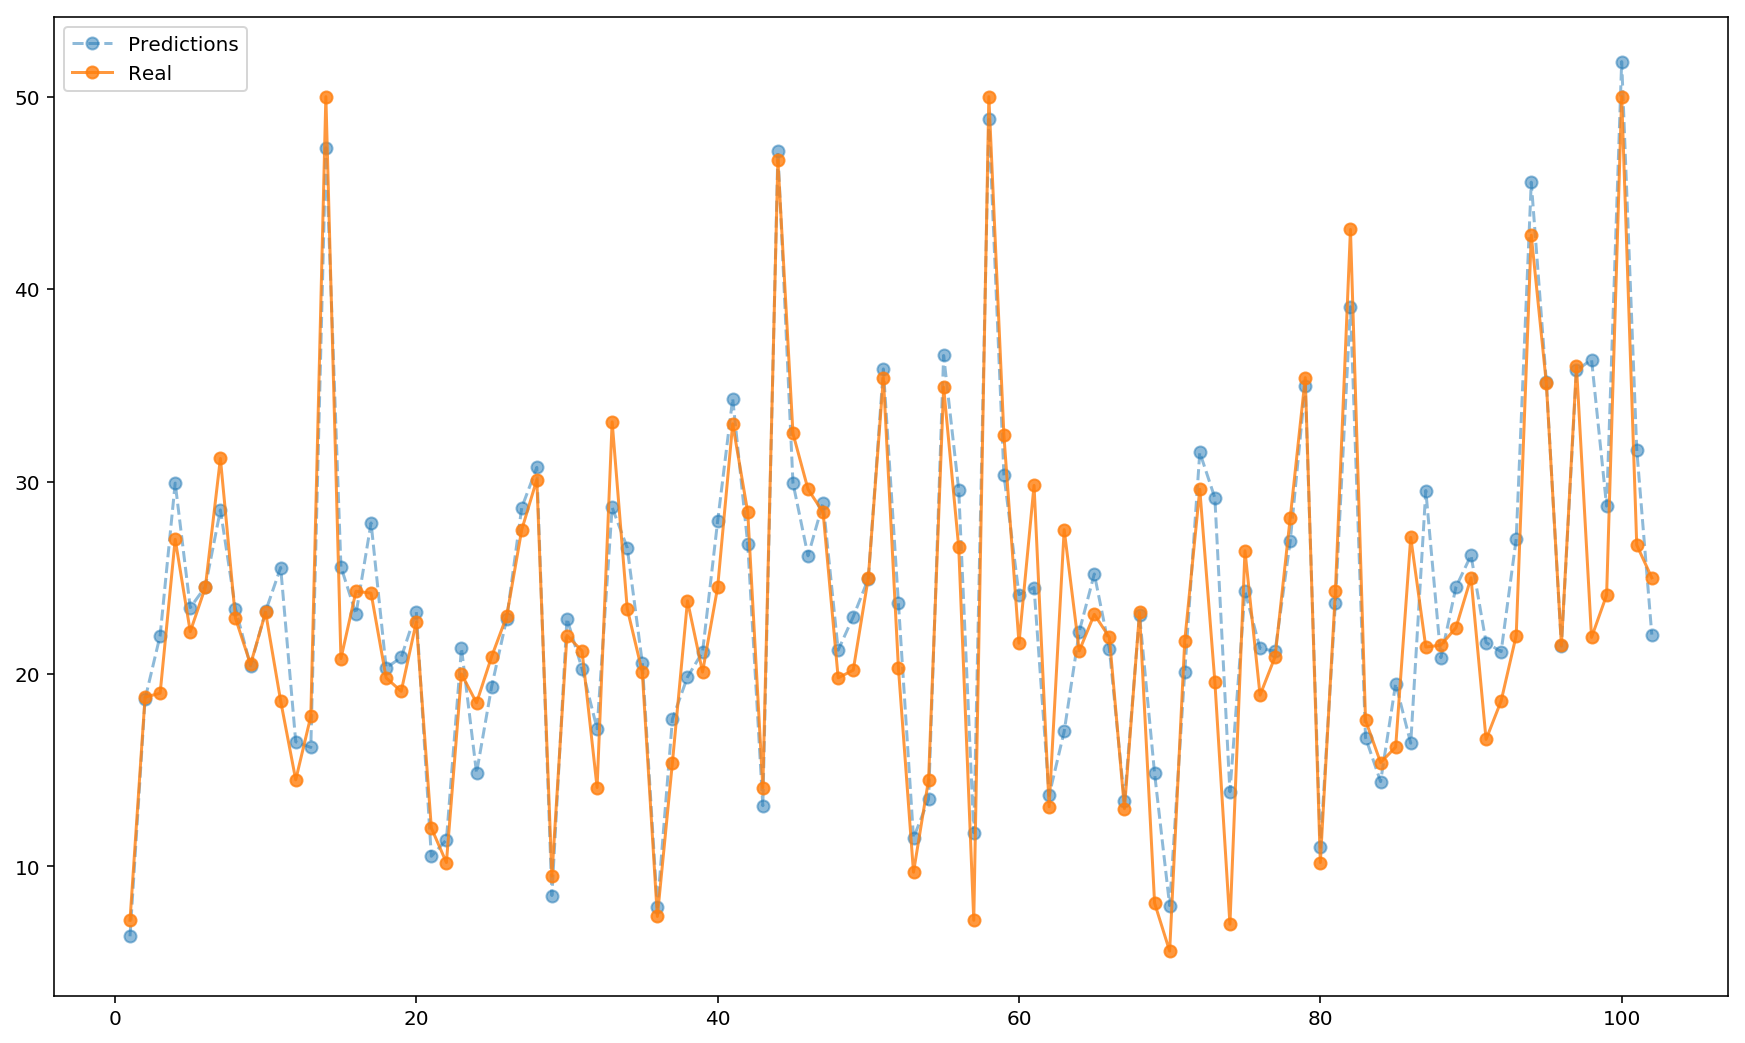

In [71]:
# 输出一些预测结果
y_preds = model.predict(x_test)

range_x = range(1, len(y_preds)+1)
plt.figure(figsize=(15,9))
plt.plot(range_x, y_preds, '--o', alpha=0.5, label='Predictions')
plt.plot(range_x, y_test, '-o', alpha=0.8, label='Real')
plt.legend()
plt.show()

## 7. 总结
+ 加了Dropout(0.2)效果不好，平均3.5左右
+ 两层网络 64->32->1 效果还行，在2.5左右
+ 三层网络 64-32-32-1 效果还行，2.5左右，并且训练的曲线一直在下降，所以epochs从100增加到200。从结果上看，大概从175个epoch开始过拟合
    + ![64-32-32-1](64-32-32-1_E200_b2.png)
+ 加了BatchNormalization 效果变差了
    + ![64-32-32-bn-1](64-32-32-bn-1_E200_b2.png)
+ 四层网络 64-32-32-16-1也还行吧
    + ![64-32-32-16-1](64-32-32-16-1_E200_b2.png)
+ 最后的结果表面我们的模型预测还是相当准确的,误差在2300美元左右